<img src="https://raw.githubusercontent.com/Qiskit/qiskit-tutorials/master/images/qiskit-heading.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

#  Advanced Randomized Benchmarking Methods

### Contributors

Shelly Garion$^{1}$ and David McKay$^{2}$

1. IBM Research Haifa, Haifa University Campus, Mount Carmel Haifa, Israel
2. IBM T.J. Watson Research Center, Yorktown Heights, NY, USA


## Introduction

**Randomized benchmarking (RB)** is a scalable technique for measuring the average gate error. Variants of the randomized benchmarking protocol provide a wide variety of information about noise parameters, including error rates for specific gates,  leakage rates, coherence errors and others.

In this tutorial the following advanced RB methods are described:

- **Inteleved RB** benchmarking individual Clifford gates via randomization. The protocol estimates the gate error of the given Clifford. The protocol is described in [1]. 

- **Purity RB:** quantifies how coherent the errors are. The protocol is based on [2,3]. 


### References

[1] Easwar Magesan, Jay M. Gambetta, B. R. Johnson, Colm A. Ryan, Jerry M. Chow, Seth T. Merkel, Marcus P. da Silva, George A. Keefe, Mary B. Rothwell, Thomas A. Ohki, Mark B. Ketchen, and M. Steffen, *Efficient measurement of quantum gate error by interleaved randomized benchmarking*, https://arxiv.org/abs/1203.4550

[2] Joel Wallman, Chris Granade, Robin Harper, and Steven T. Flammia, *Estimating the Coherence of Noise*, https://arxiv.org/abs/1503.07865

[3] David C. McKay, Stefan Filipp, Antonio Mezzacapo, Easwar Magesan, Jerry M. Chow, and Jay M. Gambetta, *A universal gate for fixed-frequency qubits via a tunable bus*, https://arxiv.org/abs/1604.03076


We should first import the relevant qiskit classes for the demonstration.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes classes
import qiskit
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, coherent_unitary_error

# Interleaved RB protocol

To benchmark the given Clifford element $C$, which has an associated noise operator $\Lambda _C$, we fix an initial state $\psi$ and perform the following steps:

### Step 1: Implement standard randomized benchmarking

For details see: https://github.com/Qiskit/qiskit-tutorials-community/blob/master/ignis/RB_overview.ipynb

We also briefy summarize it here.

For various values of $m$, choose $K$ sequences of random gates where the first $m$ gates are chosen uniformly at random
from the $n$-qubit Clifford group. The $(m+1)$th gate is chosen to be the inverse of the composition of the first $m$ random gates and can be found efficiently by the Gottesman-Knill theorem.

Assuming each Clifford element $C_{i_j}$ for each step $j$ has some associated error, $\Lambda_{i_j}$ , the sequence of gates is modeled by
$$ S_{{\bf i}_m} = \Lambda_{i_{m+1}} \circ C_{i_{m+1}} \circ \left( \bigcirc_{j=1}^m [\Lambda_{i_j} \circ C_{i_j}]\right),$$
where ${\bf i}_m = (i_1,\dots,i_m)$ and $i_{m+1}$ is uniquely determined by ${\bf i}_m$.

Next, measure the probability that the initial state is not changed by the sequence, $Tr[E_{\psi} S_{{\bf i}_m}(\rho_\psi)]$, which is called the *survival probability*. Here $\rho_\psi$ is a quantum state that takes into
account state-preparation errors and $E_\psi$ is the positive operator valued measure element that takes into account
measurement errors. In the ideal (noise-free) case the survival probability will be 1 for each sequence. 

Averaging the survival probability over the $K$ sequences gives the sequence *fidelity* $F_{seq}(m,\psi)$ and a fit to the model:
$$F_{seq}(m,\psi) = A \alpha^m + B$$
gives the depolarizing parameter $\alpha$. 
The average *error rate per a Clifford gate (EPC)* is given by 
$r = \frac{d-1}{d}(1-\alpha)$, where $d=2^n$.
The coefficients $A$ and $B$ absorb the state preparation and measurement errors as well as the error on the final gate.

###  Step 2: Generate the interleaved RB sequences

Choose $K$ sequences of Clifford elements where the first Clifford $C_{i_1}$ in each sequence is chosen uniformly at random from the $n$-qubit Clifford group, the second is always chosen to be $C$, and alternate between uniformly random Clifford elements and deterministic $C$ up to the $m$th random gate. The $(m+1)$th gate is chosen to be the inverse of the composition of the first $m$ random gates and $m$ interlaced $C$ gates.

The superoperator representing the sequence is:
$$ \mathcal{V}_{{\bf i}_m} = \Lambda_{i_{m+1}} \circ C_{i_{m+1}} \circ \left( \bigcirc_{j=1}^m [C \circ \Lambda_C \circ \Lambda_{i_j} \circ C_{i_j}]\right),$$

For each of the $K$ sequences, measure the survival probability $Tr[E_{\psi} \mathcal{V}_{{\bf i}_m}(\rho_\psi)]$ and average over the $K$ random sequences to find the new sequence fidelity $F_{\overline{seq}}(m,\psi)$.

Fit $F_{\overline{seq}}(m,\psi)$ to one of the model to obtain the depolarizing parameter $\alpha_C$, as before.


For example, we generate below sequences of 2-qubit Clifford circuits.

In [2]:
#Number of qubits
nQ = 2
#There are 2 qubits: Q0,Q1.
rb_opts = {}
#Number of Cliffords in the sequence (start, stop, steps)
rb_opts['length_vector'] = np.arange(1,200,20)
#Number of seeds (random sequences)
rb_opts['nseeds'] = 5
#Default pattern
rb_opts['rb_pattern'] = [[0,1]]
#Interleaved Clifford gates (cx gate)
rb_opts['interleaved_gates'] =  [['cx 0 1']]

rb_original_circs, xdata, rb_interleaved_circs = rb.randomized_benchmarking_seq(**rb_opts)

As an example, we print the circuit corresponding to the first original and interleaved RB sequences:

In [3]:
#Original RB circuits
print (rb_original_circs[0][0])

         ┌───┐┌───┐          ┌─────┐┌───┐      ░ ┌───┐ ┌───┐           ┌─────┐»
qr_0: |0>┤ H ├┤ S ├───────■──┤ Sdg ├┤ H ├──────░─┤ H ├─┤ S ├────────■──┤ Sdg ├»
         ├───┤├───┤┌───┐┌─┴─┐└┬───┬┘├───┤┌───┐ ░ ├───┤┌┴───┴┐┌───┐┌─┴─┐├─────┤»
qr_1: |0>┤ H ├┤ H ├┤ S ├┤ X ├─┤ H ├─┤ S ├┤ Y ├─░─┤ Y ├┤ Sdg ├┤ H ├┤ X ├┤ Sdg ├»
         └───┘└───┘└───┘└───┘ └───┘ └───┘└───┘ ░ └───┘└─────┘└───┘└───┘└─────┘»
 cr_0: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
 cr_1: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌───┐┌─┐        
«qr_0: ┤ H ├┤M├────────
«      ├───┤└╥┘┌───┐┌─┐
«qr_1: ┤ H ├─╫─┤ H ├┤M├
«      └───┘ ║ └───┘└╥┘
«cr_0: ══════╩═══════╬═
«                    ║ 
«cr_1: ══════════════╩═
«                      


In [4]:
#Interleaved RB circuits
print (rb_interleaved_circs[0][0])

         ┌───┐┌───┐          ┌─────┐┌───┐      ░       ░ ┌───┐ ┌───┐ ┌───┐┌───┐»
qr_0: |0>┤ H ├┤ S ├───────■──┤ Sdg ├┤ H ├──────░───■───░─┤ Z ├─┤ H ├─┤ S ├┤ X ├»
         ├───┤├───┤┌───┐┌─┴─┐└┬───┬┘├───┤┌───┐ ░ ┌─┴─┐ ░ ├───┤┌┴───┴┐├───┤└─┬─┘»
qr_1: |0>┤ H ├┤ H ├┤ S ├┤ X ├─┤ H ├─┤ S ├┤ Y ├─░─┤ X ├─░─┤ Y ├┤ Sdg ├┤ H ├──■──»
         └───┘└───┘└───┘└───┘ └───┘ └───┘└───┘ ░ └───┘ ░ └───┘└─────┘└───┘     »
 cr_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_1: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
«           ┌───┐┌───┐┌─┐
«qr_0: ──■──┤ H ├┤ S ├┤M├
«      ┌─┴─┐├───┤└┬─┬┘└╥┘
«qr_1: ┤ X ├┤ H ├─┤M├──╫─
«      └───┘└───┘ └╥┘  ║ 
«cr_0: ════════════╬═══╩═
«                  ║     
«cr_1: ════════════╩═════
«                        


We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates. Then, we execute the original and interleaved RB sequences using Qiskit Aer Simulator.

In [5]:
noise_model = noise.NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

In [6]:
#Original RB circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
original_result_list = []
original_qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_original_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    original_result_list.append(job.result())
    original_qobj_list.append(qobj)    
print("Finished Simulating Original Circuits")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating Original Circuits


In [7]:
#Interleaved RB circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
interleaved_result_list = []
interleaved_qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_interleaved_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    interleaved_result_list.append(job.result())
    interleaved_qobj_list.append(qobj)    
print("Finished Simulating Interleaved Circuits")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating Interleaved Circuits


### Step 3: Fit the results

From the values obtained for $\alpha$ (Step 1) and $\alpha_C$ (Step 2), the *gate error* of $\Lambda_C$, which is exactly given
by $r_C = 1-$average gate fidelity of $\Lambda_C$, is estimated by:
$ r_c^{est} = \frac{d-1}{d}(1-\alpha_C/\alpha),$
and must lie in the range $[r_C^{est}-E, r_C^{est}+E]$ where:
$$ E = \min \begin{cases} 
\frac{d-1}{d} \bigl( |\alpha-\alpha_C/\alpha|+(1-\alpha)\bigr) \\
\frac{2(d^2-1)(1-\alpha)}{\alpha d^2} + \frac{4\sqrt{1-\alpha}\sqrt{d^2-1}}{\alpha}
\end{cases}.$$ 

As an example, we calculate the average sequence fidelity for the standard and interleaved RB sequences, fit the results to the exponential curve, and compute the paraemters $\alpha$, $\alpha_C$, epc (=$r$) and epc_est (=$r_C^{est}$),
as well as the *systemtic error* $E$ and the bounds systematic_err_L = $r_C^{est}-E$ and systematic_err_R = $r_C^{est}+E$.

In [8]:
#Create the original and interleaved RB fitter
original_rb_fit = rb.RBFitter(original_result_list, xdata, rb_opts['rb_pattern'])
interleaved_rb_fit = rb.RBFitter(interleaved_result_list, xdata, rb_opts['rb_pattern'])

In [9]:
#Calculate the joint fitter
joint_rb_fit = rb.InterleavedRBFitter(original_result_list, interleaved_result_list, xdata, rb_opts['rb_pattern'])
print (joint_rb_fit.fit_int)

[{'alpha': 0.982466214495266, 'alpha_err': 0.0014392100251542014, 'alpha_c': 0.9704497593230009, 'alpha_c_err': 0.00163780215693106, 'epc_est': 0.00917318198451117, 'epc_est_err': 0.0016555712734152603, 'systematic_err': 0.01712749627258975, 'systematic_err_L': -0.007954314288078579, 'systematic_err_R': 0.026300678257100918}]


### Plot the results

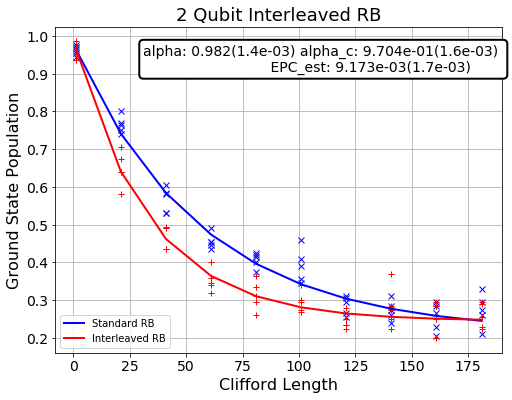

In [10]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
joint_rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Interleaved RB'%(nQ), fontsize=18)

plt.show()

# Purity RB protocol

**Purity RB** quantifies how coherent the errors are. The protocol executes the RB sequneces containing of Clifford gates, and then calculates the purity $Tr(\rho^2)$, and fits the purity result to an exponentially decaying curve.
If the noise is coherent then necessarily $Tr(\rho^2)=1$.

### Definition of the purity
The purity is defined as 
$$
\mathcal{P}  = {Tr}(\rho^2)
$$
where $\rho$ can be expressed as a sum of Pauli matrices
$$
\rho = \sum_{i} \alpha_i P_i
$$
where $i$ is a sum over $4^n$ Paulis. Therefore,
$$
\rho^2 = \sum_{ij} \alpha_i \alpha_j P_i \cdot P_j
$$
and
$$
Tr(\rho^2) = \sum_{ij} \alpha_i \alpha_j Tr(P_i P_j)
$$
If $i\ne j$ then $P_i P_j = P_k$ (where $P_k \ne \mathbf{I}$ and if $i==j$ then $P_i P_j = \mathcal{I}$). Since $Tr(P_k)=0$, then
$$
Tr(\rho^2) = \sum_i \alpha_i^2 d
$$
Now we can calculate any expectation value as,
$$
\langle \hat{A} \rangle = Tr(\hat{A} \rho)
$$
so the Pauli expectation value is
$$
\langle P_k \rangle  =  Tr(P_k \rho) 
 =  \sum_i \alpha_i Tr(P_k P_i)
 =  \alpha_k d
$$
so
$$
Tr(\rho^2) = \sum_k \langle P_k \rangle^2 /d
$$

### Step 1: Generating the purity RB sequences 

To calculate all $Z$ correlators we only need the on diagonal elements of $\rho$ (i.e. what is measured in experiment). If we apply a $\pi/2$ rotation to the density matrix and then measure the $Z$ correlator,
$$
\rho^{'}  =  e^{i P_j \pi/4} \rho e^{-i P_j \pi/4} 
$$
$$
Tr(Z \rho^{'})  =  Tr(Z e^{i P_j \pi/4} \rho e^{-i P_j \pi/4}) 
 =  Tr(e^{-i P_j \pi/4}Z e^{i P_j \pi/4} \rho)
$$
which looks like calculating the expectation value of the rotated Pauli. 

Therefore, in order to generate each of the $3^n$ circuits, we need to do (per each of the $n$ qubits) either:
- nothing (Pauli-$Z$), or
- $\pi/2$-rotation around $x$ (Pauli-$X$), or
- $\pi/2$-rotation around $y$ (Pauli-$Y$),

and then measure the result.

For example, we generate below sequences of 2-qubit Clifford purity circuits.

In [11]:
# Example of 2-qubits Purity RB
#Number of qubits
nQ = 2
rb_opts = {}
#Number of Cliffords in the sequence (start, stop, steps)
rb_opts['length_vector'] = np.arange(1,200,20)
#Number of seeds (random sequences)
rb_opts['nseeds'] = 1
#Default pattern
rb_opts['rb_pattern'] = [[0,1]]
#Parameter for purity RB
rb_opts['is_purity'] = True
rb_purity_circs, xdata, npurity = rb.randomized_benchmarking_seq(**rb_opts)
print (npurity)

9


To illustrate, we print the circuit names for purity RB (for length=0 and seed=0)

In [12]:
for j in range(len(rb_purity_circs[0])):
    print (rb_purity_circs[0][j][0].name)

rb_purity_ZZ_length_0_seed_0
rb_purity_XZ_length_0_seed_0
rb_purity_YZ_length_0_seed_0
rb_purity_ZX_length_0_seed_0
rb_purity_XX_length_0_seed_0
rb_purity_YX_length_0_seed_0
rb_purity_ZY_length_0_seed_0
rb_purity_XY_length_0_seed_0
rb_purity_YY_length_0_seed_0


As an example, we print the circuits corresponding to the first RB sequences, for each of the $3^n$ parameters.

In [13]:
for i in range(npurity):
    print ("circ no. ", i)
    print (rb_purity_circs[0][i][0])

circ no.  0
          ┌───┐ ┌─────┐┌───┐     ┌───┐┌─────┐┌───┐┌───┐ ░ ┌───┐┌───┐┌───┐┌───┐»
qr_0: |0>─┤ H ├─┤ Sdg ├┤ H ├──■──┤ X ├┤ Sdg ├┤ H ├┤ Y ├─░─┤ Y ├┤ H ├┤ S ├┤ X ├»
         ┌┴───┴┐└┬───┬┘└───┘┌─┴─┐└─┬─┘├─────┤├───┤├───┤ ░ ├───┤├───┤├───┤└─┬─┘»
qr_1: |0>┤ Sdg ├─┤ H ├──────┤ X ├──■──┤ Sdg ├┤ H ├┤ Y ├─░─┤ Y ├┤ H ├┤ S ├──■──»
         └─────┘ └───┘      └───┘     └─────┘└───┘└───┘ ░ └───┘└───┘└───┘     »
 cr_0: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
 cr_1: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
«           ┌───┐┌───┐┌───┐┌─┐
«qr_0: ──■──┤ H ├┤ S ├┤ H ├┤M├
«      ┌─┴─┐├───┤├───┤└┬─┬┘└╥┘
«qr_1: ┤ X ├┤ H ├┤ S ├─┤M├──╫─
«      └───┘└───┘└───┘ └╥┘  ║ 
«cr_0: ═════════════════╬═══╩═
«                       ║     
«cr_1: ═════════════════╩═════
«                   

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT gate. Then, we execute the purity RB sequences using Qiskit Aer Simulator.

In [15]:
#Non-coherent noise model - depolarizing noise
noise_model = noise.NoiseModel()
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

#Execute purity RB circuits 
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
purity_result_list = []
import time
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        print('Executing seed %d purity %d length %d'%(rb_seed, d, len(rb_opts['length_vector'])))
        new_circ = rb_purity_circs[rb_seed][d]
        job = qiskit.execute(new_circ, backend=backend, noise_model=noise_model, shots=shots, basis_gates=['u1','u2','u3','cx'])
        purity_result_list.append(job.result())
print("Finished Simulating Purity RB Circuits")

Executing seed 0 purity 0 length 10
Executing seed 0 purity 1 length 10
Executing seed 0 purity 2 length 10
Executing seed 0 purity 3 length 10
Executing seed 0 purity 4 length 10
Executing seed 0 purity 5 length 10
Executing seed 0 purity 6 length 10
Executing seed 0 purity 7 length 10
Executing seed 0 purity 8 length 10
Finished Simulating Purity RB Circuits


### Step 2: Calculating the purity $Tr(\rho^2)$

We made $3^n$ experiments and got $2^n$ expectation values per experiment (total of $6^n$ expectation values).

For example, for $n=2$ we get the following $4$ expectation values per each of the $9$ experiments:

Purity_ZZ: $\langle II \rangle$ $ \langle IZ \rangle$ $ \langle ZI \rangle$ $ \langle ZZ \rangle$

Purity_XZ: $\langle II \rangle$ $ \langle IZ \rangle$ $ \langle XI \rangle$ $ \langle XZ \rangle$

Purity_YZ: $\langle II \rangle$ $ \langle IZ \rangle$ $ \langle YI \rangle$ $ \langle YZ \rangle$

Purity_ZX: $\langle II \rangle$ $ \langle IX \rangle$ $ \langle ZI \rangle$ $ \langle ZX \rangle$

Purity_ZY: $\langle II \rangle$ $ \langle IY \rangle$ $ \langle ZI \rangle$ $ \langle ZY \rangle$ 

Purity_XX: $\langle II \rangle$ $ \langle IX \rangle$ $ \langle XI \rangle$ $ \langle XX \rangle$ 

Purity_XY: $\langle II \rangle$ $ \langle IY \rangle$ $ \langle XI \rangle$ $ \langle XY \rangle$ 

Purity_YX: $\langle II \rangle$ $ \langle IX \rangle$ $ \langle YI \rangle$ $ \langle YX \rangle$

Purity_YY: $\langle II \rangle$ $ \langle IY \rangle$ $ \langle YI \rangle$ $ \langle YY \rangle$

So, the purity is defined as the following sum of $16=4^n$ squares (divided by $4=2^n$):
$$\bigl( 1 + (\Sigma \langle IZ \rangle/3)^2 + (\Sigma \langle IY \rangle/3)^2 + (\Sigma \langle IX \rangle/3)^2 + (\Sigma \langle ZI \rangle/3)^2 + (\Sigma \langle XI\rangle/3)^2 + (\Sigma \langle YI\rangle/3)^2 + \\ 
\langle ZZ\rangle^2 + \langle XZ\rangle^2 + \langle YZ\rangle^2 + \langle ZX\rangle^2 + \langle ZY\rangle^2 + \langle XX\rangle^2 + \langle XY\rangle^2 + \langle YX\rangle^2 + \langle YY\rangle^2 \bigr) / 4$$
Since $\langle II\rangle=1$, and  $\langle IZ\rangle,\langle IY\rangle,\langle IX\rangle,\langle ZI\rangle,\langle XI\rangle,\langle YI\rangle$ appear 3 times each.

### Step 3: Fit the results

According to [3], assuming pure depolarizing noise $\alpha$, the density matrix after $m$ Cliffords (starting in the ground state density matrix $\rho_0$) is 
$$ \rho(m) = \alpha^m \rho_0 + (1-\alpha^m)\frac{\mathcal{I}}{d},$$
So
$$ \rho^2(m) = \alpha^{2m} \rho^2_0 + (1-\alpha^m)^2\frac{\mathcal{I}}{d^2} + 2\alpha^m(1-\alpha^m)\frac{\rho_0}{d},$$
Then
$$Tr(\rho^2[m]) = (1-1/d)\alpha^{2m} + 1/d.$$

Therefore, we fit the data to $A\alpha^{2m} + B$ and label the quantity $\frac{d-1}{d} (1-\alpha)$
as the *purity error per Clifford gate (PEPC)*.

As an example, we calculate $Tr(\rho^2)$ as described above, fit the results to the exponential curve, and compute the paraemters $\alpha$ and PEPC.

In [16]:
rbfit_purity = rb.PurityRBFitter(purity_result_list, npurity, xdata, rb_opts['rb_pattern'])
print ("fit:", rbfit_purity.fit)

fit: [{'params': array([0.70933013, 0.98727468, 0.25698225]), 'params_err': array([0.01259387, 0.0005551 , 0.00740674]), 'epc': 0.018966529835729523, 'epc_err': 0.0008488066578079781, 'pepc': 0.00954399008232576, 'pepc_err': 0.0004216943490439854}]


### Plot the results

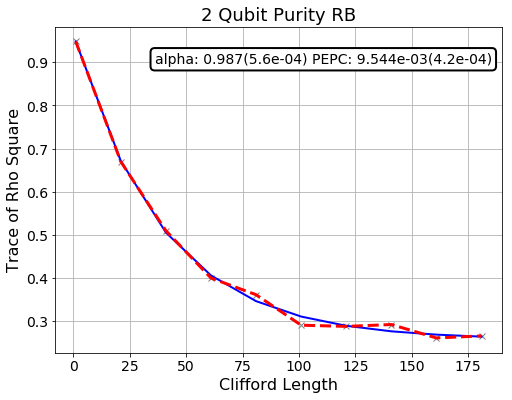

In [17]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_purity.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Purity RB'%(nQ), fontsize=18)

plt.show()

### Standard RB results

For comparison, we also print the standard RB fit results.

In [18]:
standard_result_list = []
count = 0
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        if d==0:
            standard_result_list.append(purity_result_list[count])
        count += 1

In [19]:
rbfit_standard = rb.RBFitter(standard_result_list, xdata, rb_opts['rb_pattern'])
print (rbfit_standard.fit)

[{'params': array([0.73643956, 0.98635037, 0.24610225]), 'params_err': array([0.04348855, 0.00226793, 0.04557745]), 'epc': 0.010237225630939234, 'epc_err': 0.0017244838515169812}]


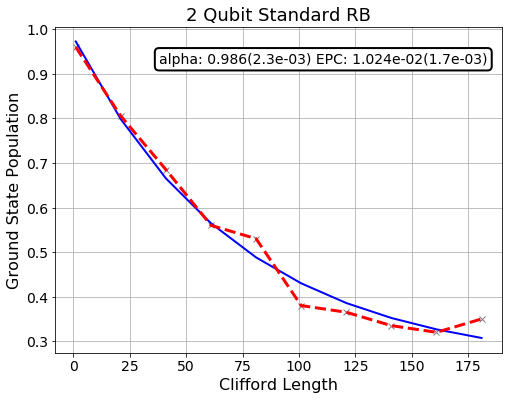

In [20]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_standard.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Standard RB'%(nQ), fontsize=18)

plt.show()

### Define a coherent noise model

We define a coherent noise model for the simulator. In this example we expect the purity RB to measure no errors, but standard RB will still measure a non-zero error.


In [21]:
#Coherent noise model
err_unitary = np.zeros([2, 2], dtype=complex)
angle_err = 0.1
for i in range(2):
    err_unitary[i, i] = np.cos(angle_err)
    err_unitary[i, (i+1) % 2] = np.sin(angle_err)
err_unitary[0, 1] *= -1.0

error = coherent_unitary_error(err_unitary)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error, 'u3')

In [22]:
#Execute purity RB circuits 
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
coherent_purity_result_list = []
import time
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        print('Executing seed %d purity %d length %d'%(rb_seed, d, len(rb_opts['length_vector'])))
        new_circ = rb_purity_circs[rb_seed][d]
        job = qiskit.execute(new_circ, backend=backend, shots=shots, noise_model=noise_model, basis_gates=['u1','u2','u3','cx'])
        coherent_purity_result_list.append(job.result())
print("Finished Simulating Purity RB Circuits")

Executing seed 0 purity 0 length 10
Executing seed 0 purity 1 length 10
Executing seed 0 purity 2 length 10
Executing seed 0 purity 3 length 10
Executing seed 0 purity 4 length 10
Executing seed 0 purity 5 length 10
Executing seed 0 purity 6 length 10
Executing seed 0 purity 7 length 10
Executing seed 0 purity 8 length 10
Finished Simulating Purity RB Circuits


In [23]:
rbfit_purity = rb.PurityRBFitter(coherent_purity_result_list, npurity, xdata, rb_opts['rb_pattern'])
print ("fit:", rbfit_purity.fit)

fit: [{'params': array([0.63447252, 1.        , 0.39394026]), 'params_err': array([0.02439911, 0.00035735, 0.02439911]), 'epc': 2.3564483697668948e-14, 'epc_err': 0.0005360186624963699, 'pepc': 1.1823875212257917e-14, 'pepc_err': 0.0002680093312481829}]


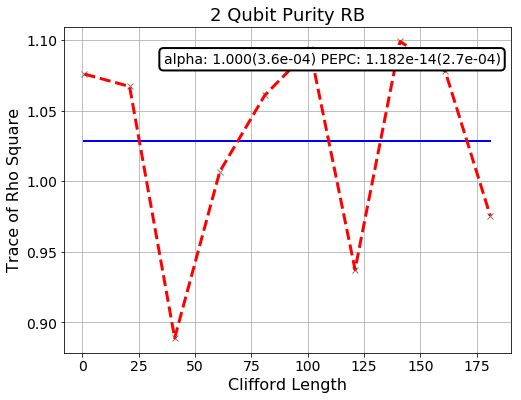

In [24]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_purity.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Purity RB'%(nQ), fontsize=18)

plt.show()

### Standard RB results

For comparison, we also print the standard RB fit results.

In [25]:
standard_result_list = []
count = 0
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        if d==0:
            standard_result_list.append(coherent_purity_result_list[count])
        count += 1

In [26]:
rbfit_standard = rb.RBFitter(standard_result_list, xdata, rb_opts['rb_pattern'])
print (rbfit_standard.fit)

[{'params': array([ 2.        ,  0.99745721, -1.11840812]), 'params_err': array([4.23902956, 0.0068336 , 4.30400632]), 'epc': 0.0019070891726288008, 'epc_err': 0.005138262027875257}]


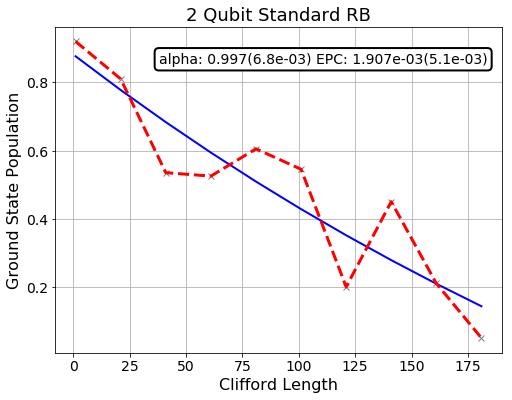

In [27]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_standard.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Standard RB'%(nQ), fontsize=18)

plt.show()